Instead of explicitly keeping track of the parents, we should be able to look at a state and compute the number of parents. If the current term is a product of $k$ basis elements, there are $k$ possible parents. If the current node is done, or the current node doesn't have any basis elements in the current term, the transition is deterministic. 

If there's no viable actions, terminate. 
Also: Instead of a set, use a list. Perhaps it's okay to have duplicate items. 

## Imports

In [4]:
from collections import defaultdict
import itertools
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceGraph_ELBO
from pyro import poutine
from pyro.optim import Adam
import gpytorch as gp
from gpytorch.kernels import RBFKernel, PeriodicKernel, ScaleKernel, ProductKernel, AdditiveKernel

In [5]:
import pdb
from pmextract import extract
import matplotlib.pyplot as plt

In [6]:
%autoreload

In [7]:
import autostat as a

In [46]:
leaf_name = "param " + str(a.hash_prog(a.Prog()))

## Fake Data

In [91]:
x = (torch.arange(100) / 100)[:,None]

In [92]:
MEAN = gp.means.ConstantMean()

In [93]:
rbf_y = a.gp_model(a.Prog(), MEAN, RBFKernel(), x, None).detach()
periodic_y = a.gp_model(a.Prog(), MEAN, PeriodicKernel(), x, None).detach()

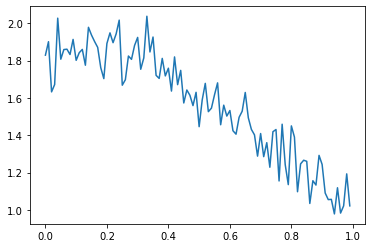

In [94]:
plt.plot(x[:,0], rbf_y.numpy())

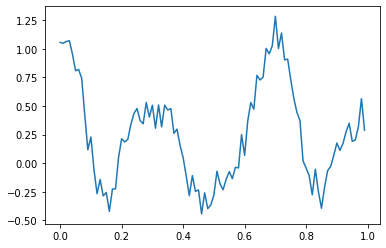

In [95]:
plt.plot(x[:,0], periodic_y.numpy())

## REINFORCE Training

In [57]:
pyro.clear_param_store()
PARENTS = defaultdict(set)
KERNS = {}
MEAN = gp.means.ConstantMean()
opt = Adam({"lr": 1e-2, "betas": (0.90, 0.999)})

In [ ]:
for _ in range(30):
    with poutine.trace() as capture:
        prog, kern, newkern = a.path_guide(capture, KERNS, PARENTS)
    for _ in range(10 if newkern else 1):
        tr = poutine.trace(a.gp_model).get_trace(prog, MEAN, kern, x, periodic_y)
        loss = -tr.log_prob_sum()
        params = [n['value'].unconstrained()
              for n in tr.nodes.values() if n['type'] == 'param']
        loss.backward()
        opt(params)
        print("Inner", loss.item())
        pyro.infer.util.zero_grads(params)
    logq = capture.trace.log_prob_sum()
    outer_loss = logq * loss.detach()
    outer_loss.backward()
    outer_params = [n['value'].unconstrained()
        for n in capture.trace.nodes.values() if n['type'] == 'param']
    opt(outer_params)
    print("Got", pyro.param(leaf_name))
    pyro.infer.util.zero_grads(outer_params) 

## GFlow Training

In [80]:
leaf_name

'param 4621608844966159198'

In [86]:
def get_path(capture):
    return [k for k,v in capture.trace.nodes.items()
          if v['type'] == 'sample']

In [104]:
pyro.clear_param_store()
KERNS = {}
MEAN = gp.means.ConstantMean()
opt = Adam({"lr": 1e-2, "betas": (0.90, 0.999)})

In [106]:
for _ in range(10):
    with poutine.trace() as capture:
        prog, logp, kern, newkern = a.path_guide(capture, KERNS)
    print(prog)

Prog(True ['PeriodicKernel'] [])
Prog(True ['PeriodicKernel'] [])
Prog(True ['RBFKernel'] [])
Prog(True ['LinearKernel'] [['PeriodicKernel', 'RBFKernel'], ['LinearKernel']])
Prog(True ['PeriodicKernel', 'RBFKernel'] [])
Prog(True ['PeriodicKernel'] [])
Prog(True ['MaternKernel', 'LinearKernel', 'PeriodicKernel', 'RBFKernel'] [])
Prog(True ['MaternKernel', 'LinearKernel', 'RBFKernel'] [['MaternKernel', 'RBFKernel'], ['MaternKernel', 'LinearKernel', 'RBFKernel']])
Prog(True ['RBFKernel'] [])
Prog(True ['LinearKernel'] [['MaternKernel', 'PeriodicKernel'], ['LinearKernel']])


In [105]:
for _ in range(120):
    with poutine.trace() as capture:
        prog, logp, kern, newkern = a.path_guide(capture, KERNS)
    for _ in range(10 if newkern else 1):
        tr = poutine.trace(a.gp_model).get_trace(prog, MEAN, kern, x, periodic_y)
        loss = -tr.log_prob_sum()
        params = [n['value'].unconstrained()
              for n in tr.nodes.values() if n['type'] == 'param']
        loss.backward()
        opt(params)
        print("Inner", loss.item())
        pyro.infer.util.zero_grads(params)
    path = get_path(capture)
    logq = capture.trace.log_prob_sum()
    kl_sample = (logq - logp + loss).detach()
    outer_loss = logq * kl_sample
    outer_loss.backward()
    outer_params = [n['value'].unconstrained()
        for n in capture.trace.nodes.values() if n['type'] == 'param']
    opt(outer_params)
    print("Got", pyro.param(leaf_name))
    pyro.infer.util.zero_grads(outer_params) 

Inner -68.04399871826172
Inner -67.71210479736328
Inner -68.12921905517578
Inner -68.26776885986328
Inner -68.06461334228516
Inner -68.12737274169922
Inner -68.3133316040039
Inner -68.33570098876953
Inner -68.24344635009766
Inner -68.25225067138672
Got tensor([   -inf,    -inf,  0.0100, -0.0100, -0.0100, -0.0100],
       requires_grad=True)
Inner 855.6427001953125
Inner 852.979736328125
Inner 849.5167236328125
Inner 845.6231079101562
Inner 841.5093383789062
Inner 837.3157348632812
Inner 833.1444091796875
Inner 829.06640625
Inner 825.1368408203125
Inner 821.4014892578125
Got tensor([   -inf,    -inf,  0.0189, -0.0032, -0.0176, -0.0032],
       requires_grad=True)
Inner 659.2432250976562
Inner 657.9329223632812
Inner 656.6788330078125
Inner 655.4490356445312
Inner 654.2483520507812
Inner 653.0692749023438
Inner 651.92626953125
Inner 650.8247680664062
Inner 649.7595825195312
Inner 648.7103271484375
Got tensor([   -inf,    -inf,  0.0282, -0.0070, -0.0217,  0.0049],
       requires_grad=Tru

Inner -59.941749572753906
Inner -59.989845275878906
Inner -60.04297637939453
Inner -60.094322204589844
Inner -60.139122009277344
Inner -60.182395935058594
Inner -60.22789764404297
Got tensor([   -inf,    -inf,  0.2669, -0.0998, -0.0755,  0.0637],
       requires_grad=True)
Inner 652.509521484375
Inner 651.4292602539062
Inner 650.3896484375
Inner 649.3905639648438
Inner 648.4047241210938
Inner 647.4382934570312
Inner 646.5330200195312
Inner 645.6351928710938
Inner 644.766845703125
Inner 643.9144897460938
Got tensor([   -inf,    -inf,  0.2717, -0.1006, -0.0785,  0.0656],
       requires_grad=True)
Inner -58.72852325439453
Inner -58.819129943847656
Inner -58.920143127441406
Inner -59.00133514404297
Inner -59.07855987548828
Inner -59.157081604003906
Inner -59.22736358642578
Inner -59.289756774902344
Inner -59.353370666503906
Inner -59.415184020996094
Got tensor([   -inf,    -inf,  0.2766, -0.1013, -0.0813,  0.0673],
       requires_grad=True)
Inner 32.183616638183594
Inner 31.2173995971679

Inner 356.6834716796875
Inner 350.30023193359375
Inner 343.8925476074219
Inner 337.44708251953125
Inner 330.9854736328125
Got tensor([   -inf,    -inf,  0.6802, -0.1839, -0.2454,  0.1068],
       requires_grad=True)
Inner -68.17913055419922
Got tensor([   -inf,    -inf,  0.6880, -0.1845, -0.2493,  0.1068],
       requires_grad=True)
Inner -59.037803649902344
Inner -59.091087341308594
Inner -59.17017364501953
Inner -59.22657012939453
Inner -59.28050994873047
Inner -59.343345642089844
Inner -59.401588439941406
Inner -59.44994354248047
Inner -59.49805450439453
Inner -59.548194885253906
Got tensor([   -inf,    -inf,  0.6948, -0.1851, -0.2528,  0.1071],
       requires_grad=True)
Inner -58.756187438964844
Inner -58.828025817871094
Inner -58.86469268798828
Inner -58.91059112548828
Inner -58.96546173095703
Inner -59.016578674316406
Inner -59.06108856201172
Inner -59.101036071777344
Inner -59.14221954345703
Inner -59.188621520996094
Got tensor([   -inf,    -inf,  0.7007, -0.1857, -0.2558,  0.1